In [120]:
import kagglehub
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Download latest version
path = kagglehub.dataset_download("nagavedareddy/heartdiseasedata")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'heartdiseasedata' dataset.
Path to dataset files: /kaggle/input/heartdiseasedata


In [121]:
# We have the dataset "heart-disease.csv" in the path
os.listdir(path)

['heart-disease.csv']

---
# Heart Disesase Dataset and Stats
---

In [122]:
# Loading the dataset
print('Loading heart disease dataset...')
df = pd.read_csv(path + '/heart-disease.csv')
print('Dataset loaded successfully...\n')

print(df.info())
corr_matrix = df.corr()

Loading heart disease dataset...
Dataset loaded successfully...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
None


In [123]:
# Find highly correlated features
threshold = 0.7
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)

# Filter out self-correlations (correlation = 1)
high_corr = corr_pairs[(corr_pairs < 1) & (abs(corr_pairs) > threshold)]
print(high_corr)
if(len(high_corr) == 0):
  print('No corelated features')

Series([], dtype: float64)
No corelated features


In [124]:
print(df.columns, '\n')
print('Target value count:')
print(df['target'].value_counts())

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object') 

Target value count:
target
1    165
0    138
Name: count, dtype: int64


---
# Data Preparation
---

In [125]:
# Identify categorical columns
categorical_cols = ['cp', 'thal', 'slope']

# One-hot encode categorical columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Features and target
X = df.drop("target", axis=1)
y = df["target"]

# Scale features so that SVM models give better results
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

---
PCA
---

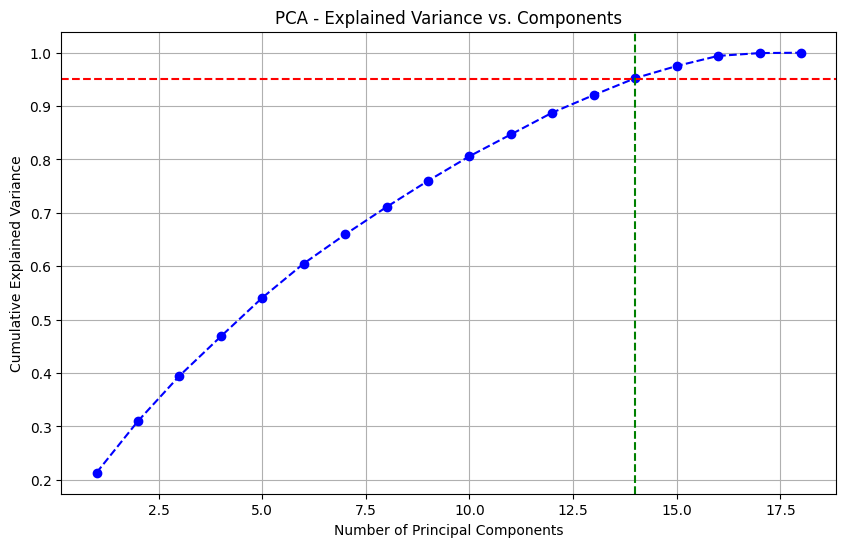


Recommended number of components: 14 (covers ~95% variance)


In [126]:
# Apply PCA (keep all components first)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Find elbow point (where additional variance gain < 1%)
elbow_point = np.argmax(cumulative_variance >= 0.95) + 1  # first component where 95% variance is covered


# Plot explained variance
# Plot cumulative explained variance
plt.figure(figsize=(10,6))
plt.plot(range(1, len(explained_variance)+1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% Variance Threshold")
plt.axvline(x=elbow_point, color='g', linestyle='--', label=f"Elbow Point: {elbow_point} PCs")

plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Explained Variance vs. Components")
plt.grid(True)
plt.show()

print(f"\nRecommended number of components: {elbow_point} (covers ~95% variance)")

In [127]:
# Re-run PCA with optimal components
pca = PCA(n_components=elbow_point)
X_reduced = pca.fit_transform(X_scaled)

# ------------------------------
# 4. Train-Test Split
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42, stratify=y
)

---
# Grid serach on hyperparameters
---

In [128]:
# Train SVM with GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=1, cv=5)
grid.fit(X_train, y_train)

# Best model
best_svm = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


---
# Testing and Evaluation
---

Accuracy: 80.33%

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.68      0.76        28
           1       0.77      0.91      0.83        33

    accuracy                           0.80        61
   macro avg       0.82      0.79      0.80        61
weighted avg       0.81      0.80      0.80        61



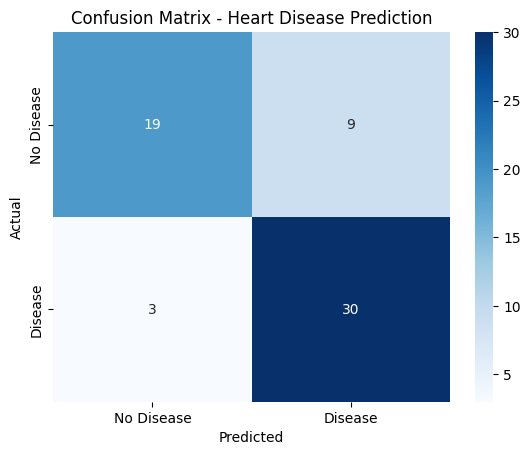

In [129]:
# Predictions
y_pred = best_svm.predict(X_test)

# Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Disease", "Disease"], yticklabels=["No Disease", "Disease"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Heart Disease Prediction")
plt.show()